In [ ]:
!pip install pykrige
!pip install geopandas
!pip install matplotlib

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from pykrige.ok import OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# --- 1. Load and Prepare the Data ---
# Load the CSV file into a DataFrame.
df = pd.read_csv('/content/Air_pollution.csv')

In [ ]:
# Drop any rows where the latitude or longitude are missing, as they are essential.
df.dropna(subset=['latitude', 'longitude'], inplace=True)

# Define the variable you want to interpolate.
# You can change this to 'CO', 'NH3', 'NO2', 'OZONE', 'PM10', or 'SO2'.
variable_of_interest = 'PM2.5'

In [ ]:
# --- 2. Data Cleaning ---
# Convert the variable of interest to a numeric type, forcing errors to NaN.
df[variable_of_interest] = pd.to_numeric(df[variable_of_interest], errors='coerce')

# Drop any rows with NaN values in the selected column to ensure a clean dataset.
df.dropna(subset=[variable_of_interest], inplace=True)


In [ ]:
# --- 3. Create a GeoDataFrame and Handle CRS ---
# Create a geometry column from latitude and longitude.
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# The coordinates are in geographic degrees (WGS84, EPSG:4326).
# Kriging requires a projected CRS with units in meters for accurate distance calculations.
gdf.crs = 'EPSG:4326'

# Convert the GeoDataFrame to a projected CRS. UTM Zone 43N (EPSG:32643)
# is a suitable choice for your data's location.
gdf = gdf.to_crs(epsg=32643)
print("Data has been reprojected to:", gdf.crs)

Data has been reprojected to: EPSG:32643


In [ ]:
# --- 4. Prepare Data for Kriging ---
# Extract coordinates and the variable of interest from the projected GeoDataFrame.
x = gdf.geometry.x.values
y = gdf.geometry.y.values
z = gdf[variable_of_interest].values

# Define the interpolation grid.
x_min, y_min, x_max, y_max = gdf.total_bounds
grid_x = np.linspace(x_min, x_max, 200)
grid_y = np.linspace(y_min, y_max, 200)

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'exponential' Variogram Model
Partial Sill: 418.66307245524774
Full Sill: 418.66315986759474
Range: 318499.5196658749
Nugget: 8.741234698662981e-05 



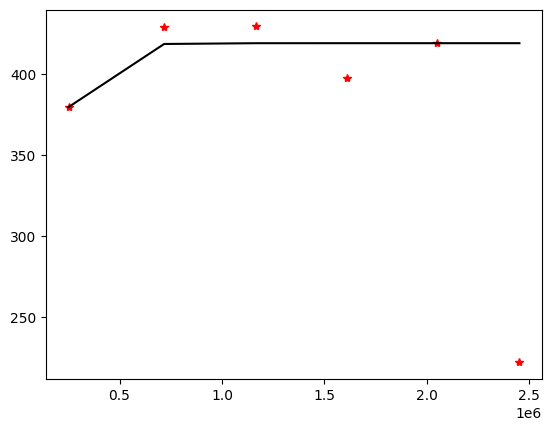

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [ ]:
# Apply ordinary kringing
OK = OrdinaryKriging(
    x, y, z,
    variogram_model = 'exponential',
    nlags=6,
    verbose=True,
    enable_plotting=True
)



z_interp, ss = OK.execute(
    'grid', grid_lon, grid_lat,
    n_closest_points=15,
    backend='loop'
)


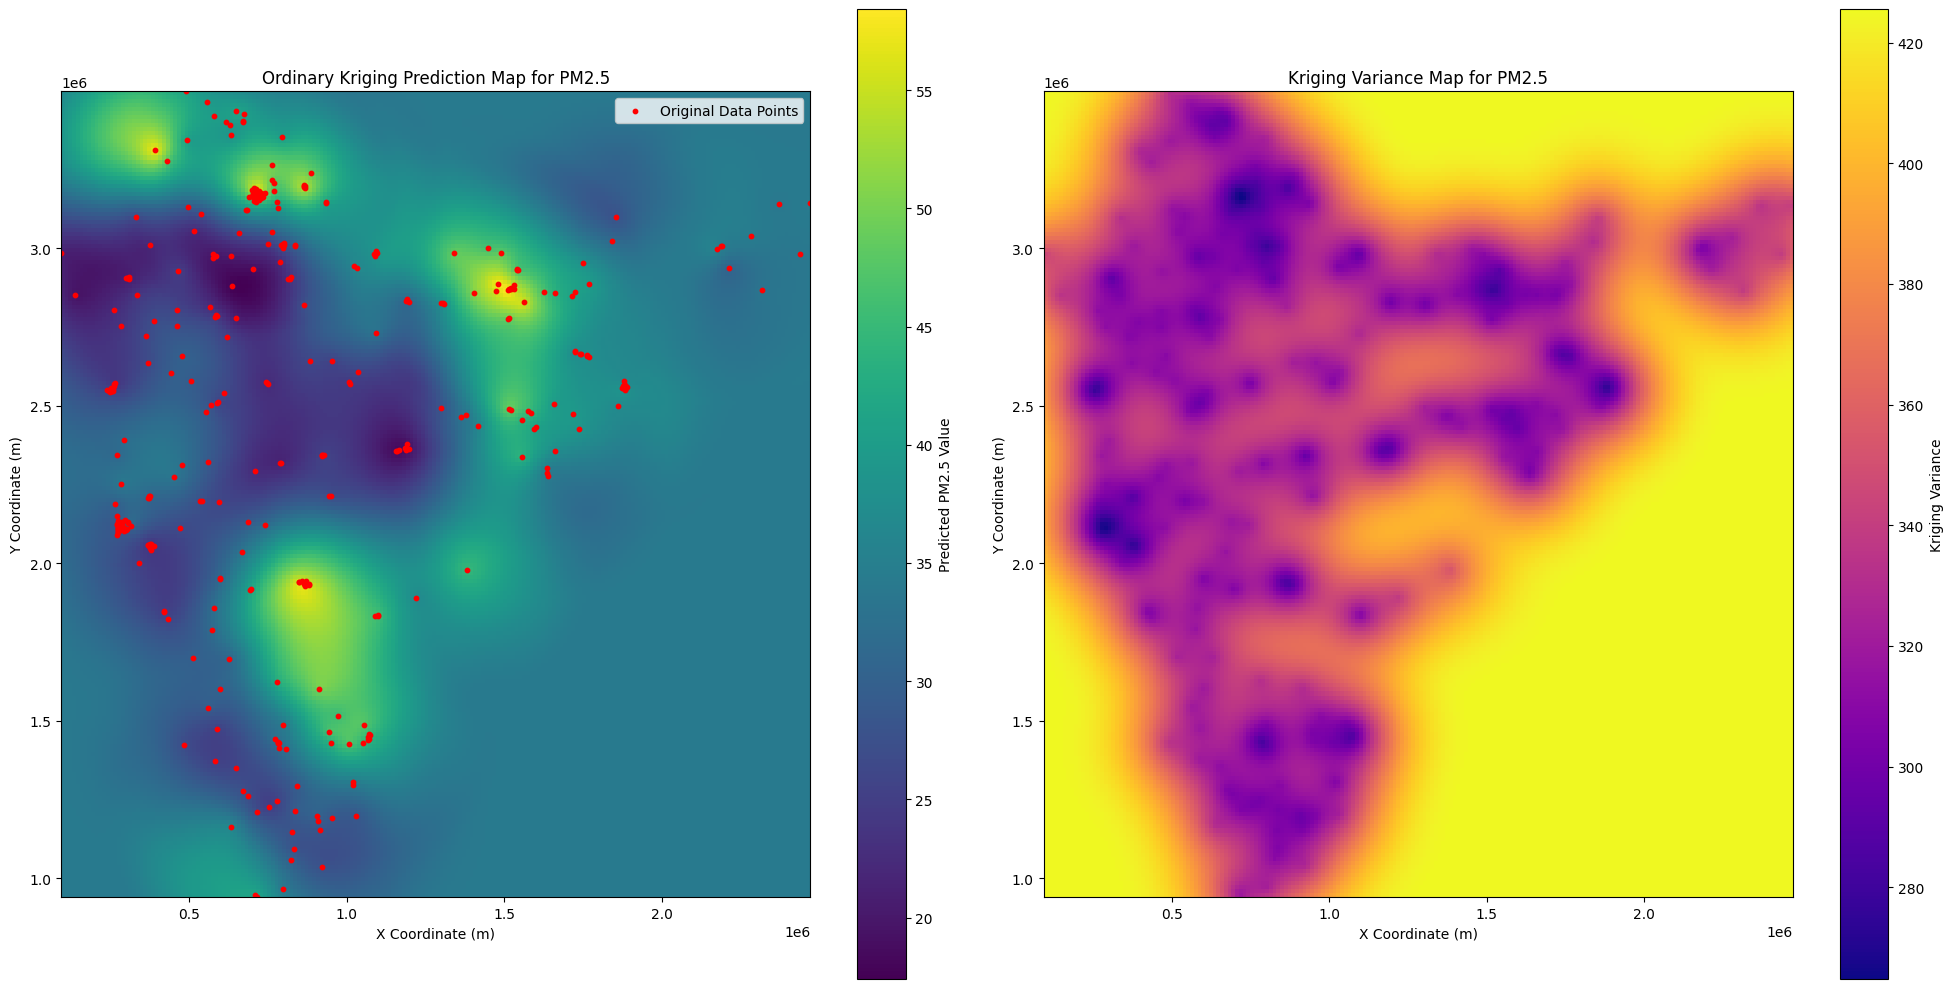

In [ ]:
# --- 6. Visualize the Results ---
# Create a figure to hold both plots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plot the predicted values.
im1 = ax1.imshow(z_pred, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='viridis')
fig.colorbar(im1, ax=ax1, label='Predicted PM2.5 Value')
ax1.set_title('Ordinary Kriging Prediction Map for PM2.5')
ax1.set_xlabel('X Coordinate (m)')
ax1.set_ylabel('Y Coordinate (m)')
ax1.scatter(x, y, c='red', s=10, label='Original Data Points', zorder=2) # Add original points
ax1.legend()

# Plot the kriging variance (uncertainty).
im2 = ax2.imshow(ss_pred, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap='plasma')
fig.colorbar(im2, ax=ax2, label='Kriging Variance')
ax2.set_title('Kriging Variance Map for PM2.5')
ax2.set_xlabel('X Coordinate (m)')
ax2.set_ylabel('Y Coordinate (m)')

plt.tight_layout()
plt.show()
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#library for ordinary kriging
from pykrige.ok import OrdinaryKriging
